# Model Project: Relationship and Casuality between interest rates and inflation in the US, using the Vector Autoregressive model.

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.sandwich_covariance import cov_hac_simple
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

Next, we read the Data and normalize the data

In [5]:
# Load the data from the Excel file
data = pd.read_excel("cpi_rate.xls", index_col="observation_date")
data.index.freq = 'QS'

data['cpi_normalized'] = (data['cpi'] - data['cpi'].min()) / (data['cpi'].max() - data['cpi'].min())
data['rate_normalized'] = (data['rate'] - data['rate'].min()) / (data['rate'].max() - data['rate'].min())

data['cpi_diff'] = data['cpi'].diff()
data['rate_diff'] = data['rate'].diff()


We then take the first difference to remove trend 

The two time series consists of the Consumer Price Index and the federal funds rate in the US. Both datasets are in quarters.

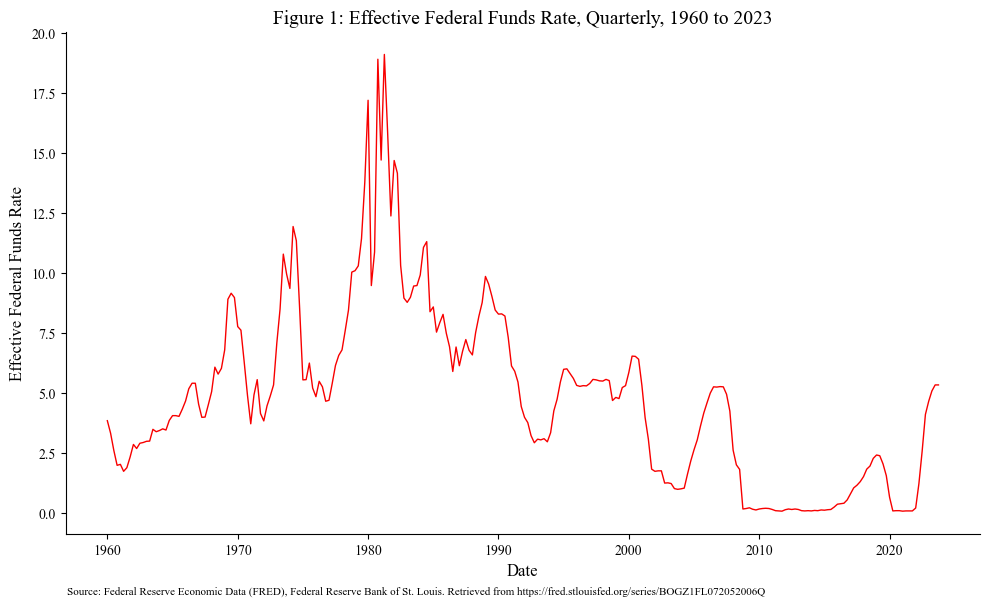

In [6]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

data = pd.read_excel('BOGZ1FL072052006Q.xls', parse_dates=['observation_date'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(data['observation_date'], data['BOGZ1FL072052006Q'], color='#F80000', linewidth=1)

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Figure 1: Effective Federal Funds Rate, Quarterly, 1960 to 2023', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Effective Federal Funds Rate', fontsize=12)

ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figtext(0.77, 0.001, 'Source: Federal Reserve Economic Data (FRED), Federal Reserve Bank of St. Louis. Retrieved from https://fred.stlouisfed.org/series/BOGZ1FL072052006Q', horizontalalignment='right', fontsize=8, color='black')

plt.tight_layout()
plt.show()

Throughout the period, there are noticeable shift in the levels of the interest rate, indicating
periods of expansionary and contractionary monetary policy. The highest peak is in the
early 1980’s, where the FED lead an aggressive contractionary monetary policy in order to
combat high inflation, at the time. Past this period, the rate trends downward, stabilizing
around the late 1990’s and early 2000’s, and then decrease further, nearing the zero lower
bound, following the financial crisis of 2008. In the beginning of the 2020’s, rates are seen to
be upward trending, indicating the beginning of a new period with contractionary monetary
policy.

Text(0.815, 0.001, 'Source: Federal Reserve Economic Data (FRED), Federal Reserve Bank of St. Louis. Retrieved from https://fred.stlouisfed.org/series/CPGRLE01USQ659N')

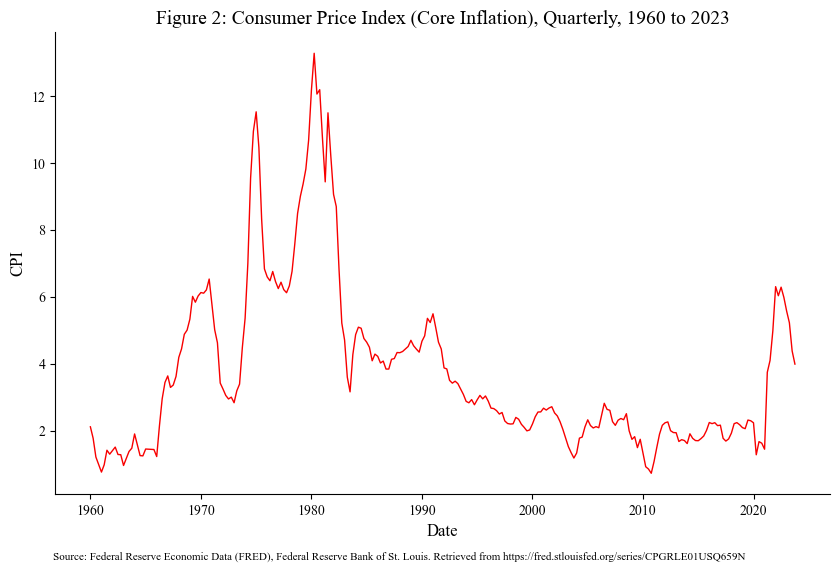

In [7]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

data = pd.read_excel('CPGRLE01USQ659N.xls', parse_dates=['observation_date'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(data['observation_date'], data['CPGRLE01USQ659N'], color='#F80000', linewidth=1)

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Figure 2: Consumer Price Index (Core Inflation), Quarterly, 1960 to 2023', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPI', fontsize=12)

ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figtext(0.815, 0.001, 'Source: Federal Reserve Economic Data (FRED), Federal Reserve Bank of St. Louis. Retrieved from https://fred.stlouisfed.org/series/CPGRLE01USQ659N', horizontalalignment='right', fontsize=8, color='black')

The Consumer Price index shows noticeable volatility throughout the period, with significant
spikes through the 1970’s and early 1980’s. Past this period the trend is downwards-going,
suggesting a period of more controlled inflation levels, until the beginning of the 2020’s where
inflation has once more spiked.

Below code graphs the first differences of both variables. 

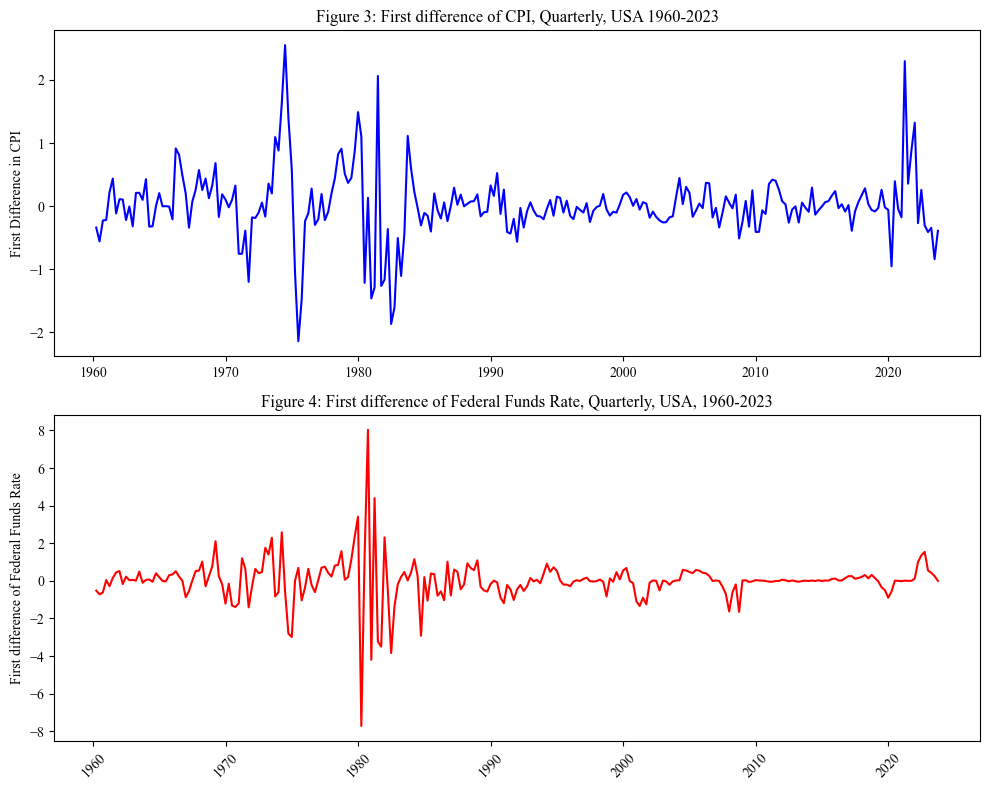

In [8]:
# Load the data
data = pd.read_excel("cpi_rate.xls", index_col="observation_date")
data.index.freq = 'QS'  # Setting the frequency of the index since the time series is quarterly

data['cpi_diff'] = data['cpi'].diff()
data['rate_diff'] = data['rate'].diff()

# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot 'cpi_diff'
axs[0].plot(data.index, data['cpi_diff'], color='blue')
axs[0].set_title('Figure 3: First difference of CPI, Quarterly, USA 1960-2023')
axs[0].set_ylabel('First Difference in CPI')

# Plot 'rates_diff'
axs[1].plot(data.index, data['rate_diff'], color='red')
axs[1].set_title('Figure 4: First difference of Federal Funds Rate, Quarterly, USA, 1960-2023')
axs[1].set_ylabel('First difference of Federal Funds Rate')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set x-axis major locator and formatter to show every ten years
years = mdates.YearLocator(10)  # Show every ten years
years_fmt = mdates.DateFormatter('%Y')
for ax in axs:
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The graphs of the first differences now exhibit a more stationairy process. In order to test for stationarity, the Augmented Dickey-Fuller (ADF) statistics and corresponding
p-values are calculated, with the following code.

In [9]:
cpi_diff = data['cpi'].diff().dropna()
result = adfuller(cpi_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.569567798426701
p-value: 1.4780014128068416e-06


In [10]:
rate_diff = data['rate'].diff().dropna()
result = adfuller(rate_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.788840132605962
p-value: 2.3933687648321532e-09


The p-value for both variables are below the critical values
of a significance level of 5%, indicating the H0 hypothesis of no stationarity in the residuals of the first differences is rejected, indicating stationarity of the residuals of order one I(0).

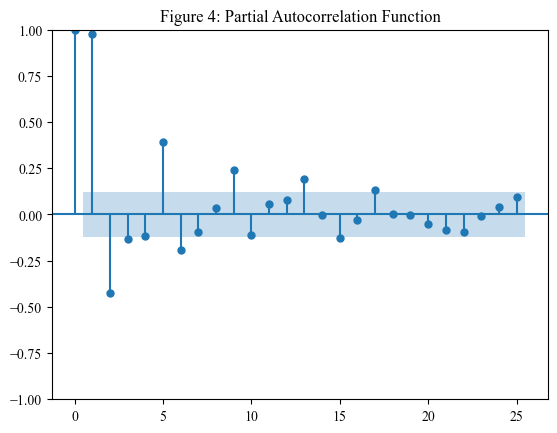

In [11]:
plot_pacf(data['cpi'])
plt.title('Figure 4: Partial Autocorrelation Function')
plt.show()

Based on the plots from figure 5 and 6, it appears that the first four lags are significant,
meaning that the first four lags contain significant auto correlation and partial autocorrelation.
From these insights, consider a VAR(4) model.

In [12]:
data = data[['rate', 'cpi']]
model = VAR(data)
model_fit = model.fit(maxlags=4)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, May, 2024
Time:                     11:25:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.38685
Nobs:                     252.000    HQIC:                  -1.53751
Log likelihood:          -490.637    FPE:                   0.194195
AIC:                     -1.63896    Det(Omega_mle):        0.181033
--------------------------------------------------------------------
Results for equation rate
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.166930         0.126312            1.322           0.186
L1.rate         0.951100         0.063681           14.935           0.000
L1.cpi         -0.414003         0.160523           -2.579           0.010
L2.rate   

The statistical outputs summarized in table 2 indicate how changes in one of the variables,
ie. inflation or interest rates, can lead to adjustments in the other variable, in a four-lagged
period. The relatively low values of the AIC, BIC and HQIC, all indicate a somewhat descent
balance between model fit and complexity. The FPE indicates that the model is adequate
in its predictive capabilities, while the determinant of the of the residuals covariance matrix
is also somewhat satisfactory, but a lower determinant value would be preferred, as the the
relationship between interest rates and inflation, would be captured better.

The correlation matrix indicates that the VAR(4) model has a relatively small shared unexplained variation of the variables.

Misspecification test for the model is carried out.

In [13]:
# Residuals from the model
residuals = model_fit.resid

# Apply tests to each variable's residuals
for column in residuals.columns:
    # Test for autocorrelation of residuals using Ljung-Box test
    print(f"\nLjung-Box test for autocorrelation in residuals of {column}:")
    ljung_box_result = acorr_ljungbox(residuals[column], lags=[10], return_df=True)
    print(ljung_box_result)

    # Test for normality of residuals using Jarque-Bera test
    jb_test = jarque_bera(residuals[column])
    print(f"\nJarque-Bera test for normality of residuals for {column}:")
    print(f"JB statistic: {jb_test[0]}, p-value: {jb_test[1]}")

# Assuming the model's fitted values for one of the variables (e.g., 'rate') to illustrate the heteroskedasticity test
exog = np.column_stack([model_fit.fittedvalues['rate'], np.ones(len(model_fit.fittedvalues))])
bp_test = het_breuschpagan(residuals['rate'], exog)
print(f"\nBreusch-Pagan test for heteroskedasticity in residuals of 'cip_diff':")
print(f"BP Statistic: {bp_test[0]}, p-value: {bp_test[1]}")


Ljung-Box test for autocorrelation in residuals of rate:
      lb_stat  lb_pvalue
10  22.012264   0.015042

Jarque-Bera test for normality of residuals for rate:
JB statistic: 1879.5821272333437, p-value: 0.0

Ljung-Box test for autocorrelation in residuals of cpi:
      lb_stat  lb_pvalue
10  36.177526   0.000078

Jarque-Bera test for normality of residuals for cpi:
JB statistic: 415.12837773196094, p-value: 7.178242647434977e-91

Breusch-Pagan test for heteroskedasticity in residuals of 'cip_diff':
BP Statistic: 54.9332806849058, p-value: 1.2469160129967837e-13


Here it seen that: The model has autocorellation of the residuals but the residuals are normaly distributed and there is no heteroscedasticity.

Granger casuality is not testes.

In [14]:
# Test for Granger causality from 'rate' to 'cpi'
result_cpi_to_rate = model_fit.test_causality(caused='rate', causing='cpi', kind='f')

# Test for Granger causality from 'cpi' to 'rate'
result_rate_to_cpi = model_fit.test_causality(caused='cpi', causing='rate', kind='f')

# Print the test results
print("Granger causality test results (cpi -> rate):\n", result_cpi_to_rate)
print("\nGranger causality test results (rate -> cpi):\n", result_rate_to_cpi)

Granger causality test results (cpi -> rate):
 <statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cpi does not Granger-cause rate: reject at 5% significance level. Test statistic: 4.039, critical value: 2.390>, p-value: 0.003>

Granger causality test results (rate -> cpi):
 <statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: rate does not Granger-cause cpi: reject at 5% significance level. Test statistic: 31.905, critical value: 2.390>, p-value: 0.000>


Causality is found to go both ways, indicating that inflation affects interest rates and vice verca.

Now co-integration is tested.

In [15]:

def test_cointegration(data):
    data = data.astype(float)
    
    # Perform the Johansen cointegration test
    johansen_test = coint_johansen(data, det_order=0, k_ar_diff=model_fit.k_ar - 1)
    
    # Output the test statistics and critical values for evaluation
    result = {
        'trace_stat': johansen_test.lr1,  # Test statistics for each rank
        'trace_crit_values': johansen_test.cvt,  # Critical values for each rank (90%, 95%, 99%)
        'eigen_stat': johansen_test.lr2,  # Eigenvalues test statistics
        'eigen_crit_values': johansen_test.cvm  # Eigenvalues critical values
    }
    return result

# Call the function and print the results
cointegration_results = test_cointegration(data)
print("Trace Statistics and Critical Values:")
print(cointegration_results['trace_stat'])
print(cointegration_results['trace_crit_values'])

print("\nEigenvalues Statistics and Critical Values:")
print(cointegration_results['eigen_stat'])
print(cointegration_results['eigen_crit_values'])

Trace Statistics and Critical Values:
[27.81751762  8.31683587]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigenvalues Statistics and Critical Values:
[19.50068175  8.31683587]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


For the VAR(4) model both the trace- and eigenvalue H0 hypothesis are accepted at the 1%,
5% and 10% significance levels.

Now for model selection, we look at the minimum ammount of lags which minimizes the information criteria the FPE.

In [16]:
sorted_order=model.select_order(maxlags=11)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.688       3.717       39.98       3.700
1      -0.9244     -0.8386      0.3968     -0.8898
2       -1.282      -1.139      0.2775      -1.224
3       -1.386      -1.186      0.2500      -1.306
4       -1.598      -1.341      0.2024      -1.494
5       -1.689      -1.375      0.1847      -1.563
6       -1.796     -1.424*      0.1660      -1.646
7       -1.779      -1.350      0.1689      -1.606
8       -1.872      -1.386      0.1538      -1.677
9       -1.905      -1.362      0.1489     -1.686*
10     -1.913*      -1.312     0.1478*      -1.671
11      -1.882      -1.225      0.1524      -1.617
--------------------------------------------------


Based on the above output, consider a VAR(10)

In [17]:
data = data[['rate', 'cpi']]
model = VAR(data)
model_fit = model.fit(maxlags=10)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, May, 2024
Time:                     11:25:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.32105
Nobs:                     246.000    HQIC:                  -1.67855
Log likelihood:          -420.017    FPE:                   0.146799
AIC:                     -1.91952    Det(Omega_mle):        0.124615
--------------------------------------------------------------------
Results for equation rate
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.093721         0.134345            0.698           0.485
L1.rate          0.945070         0.067631           13.974           0.000
L1.cpi          -0.488481         0.206960           -2.360           0.018
L2.ra

The increase in the amount of lags appear to enhance the VAR models ability to fit and predict the data, while
still maintaining a proper balance between model fit and complexity.

The correlation coefficient in the correlation matrix of the residuals for the VAR(10) model
increases from 0.091057 to 0.208522. This indicates that the residuals in the VAR(10) model
are more correlated than those in the simpler VAR(4) model, meaning that the VAR(4)
model could be more successful in capturing the underlying relationship and dynamics of
interest rates and inflation. The fact that the correlation between the residuals increases in
the VAR(10) model could suggest, that with the increase in lags follows slight over-fitting.

In [18]:
residuals = model_fit.resid

# Apply tests to each variable's residuals
for column in residuals.columns:
    # Test for autocorrelation of residuals using Ljung-Box test
    print(f"\nLjung-Box test for autocorrelation in residuals of {column}:")
    ljung_box_result = acorr_ljungbox(residuals[column], lags=[10], return_df=True)
    print(ljung_box_result)

    # Test for normality of residuals using Jarque-Bera test
    jb_test = jarque_bera(residuals[column])
    print(f"\nJarque-Bera test for normality of residuals for {column}:")
    print(f"JB statistic: {jb_test[0]}, p-value: {jb_test[1]}")

# Assuming the model's fitted values for one of the variables (e.g., 'rate') to illustrate the heteroskedasticity test
exog = np.column_stack([model_fit.fittedvalues['rate'], np.ones(len(model_fit.fittedvalues))])
bp_test = het_breuschpagan(residuals['rate'], exog)
print(f"\nBreusch-Pagan test for heteroskedasticity in residuals of 'rate':")
print(f"BP Statistic: {bp_test[0]}, p-value: {bp_test[1]}")


Ljung-Box test for autocorrelation in residuals of rate:
     lb_stat  lb_pvalue
10  1.862069   0.997292

Jarque-Bera test for normality of residuals for rate:
JB statistic: 1213.6175459631447, p-value: 2.926161713538809e-264

Ljung-Box test for autocorrelation in residuals of cpi:
    lb_stat  lb_pvalue
10  9.53431   0.482254

Jarque-Bera test for normality of residuals for cpi:
JB statistic: 309.37400051191327, p-value: 6.611338090471355e-68

Breusch-Pagan test for heteroskedasticity in residuals of 'rate':
BP Statistic: 52.321443414431734, p-value: 4.712009943181797e-13


Misspecification test for the VAR(10) model concludes no autocorrelation of the residuals, the residuals are normally distributed and there is no heteroscedasticity.

In [19]:
# Test for Granger causality from 'rate' to 'cpi'
result_cpi_to_rate = model_fit.test_causality(caused='rate', causing='cpi', kind='f')

# Test for Granger causality from 'cpi' to 'rate'
result_rate_to_cpi = model_fit.test_causality(caused='cpi', causing='rate', kind='f')

# Print the test results
print("Granger causality test results (cpi -> rate):\n", result_cpi_to_rate)
print("\nGranger causality test results (rate -> cpi):\n", result_rate_to_cpi)

Granger causality test results (cpi -> rate):
 <statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cpi does not Granger-cause rate: fail to reject at 5% significance level. Test statistic: 1.845, critical value: 1.852>, p-value: 0.051>

Granger causality test results (rate -> cpi):
 <statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: rate does not Granger-cause cpi: reject at 5% significance level. Test statistic: 11.920, critical value: 1.852>, p-value: 0.000>


Granger Causality for the VAR(10) model shows that inflations granger-causes interest rates but interest rates does not granger-cause inflation. 

In [20]:
def test_cointegration(data):
    data = data.astype(float)
    
    # Perform the Johansen cointegration test
    johansen_test = coint_johansen(data, det_order=0, k_ar_diff=model_fit.k_ar - 1)
    
    # Output the test statistics and critical values for evaluation
    result = {
        'trace_stat': johansen_test.lr1,  # Test statistics for each rank
        'trace_crit_values': johansen_test.cvt,  # Critical values for each rank (90%, 95%, 99%)
        'eigen_stat': johansen_test.lr2,  # Eigenvalues test statistics
        'eigen_crit_values': johansen_test.cvm  # Eigenvalues critical values
    }
    return result

# Call the function and print the results
cointegration_results = test_cointegration(data)
print("Trace Statistics and Critical Values:")
print(cointegration_results['trace_stat'])
print(cointegration_results['trace_crit_values'])

print("\nEigenvalues Statistics and Critical Values:")
print(cointegration_results['eigen_stat'])
print(cointegration_results['eigen_crit_values'])

Trace Statistics and Critical Values:
[20.84518411  4.31277403]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigenvalues Statistics and Critical Values:
[16.53241008  4.31277403]
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


For the VAR(10) model, the first trace value H0 hypothesis
is accepted at the 1%, 5% and 10% significance levels, while the second is only accepted at
18
the 10% and 5% significance level. Both of the eigenvalue H0 hypothesis for the VAR(10)
model, are only accepted at the 5% and 10% significance levels.

#

# Summary and conclussion

This project analyses the co-integration and causality between
interest rates and inflation in the US, by analysing two vector autoregressive models, one
with 4 lags and one with 10 lags. Both the VAR(4) and VAR(10) model exhibited strong
evidence of co-integration. The VAR(4) model found bilateral causality between interest
rates and inflation, while the VAR(10) model found unilateral causality, ie. inflation causes
interest rates, but interest rates did not cause inflation, which indicates that short term
effects of interest rates are statistically insignificant for long run inflation.